### Analyse the accuracies

In [1]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

import seaborn as sns
from IPython.display import display, Markdown

<h3> Dictionary for each dataset to its txt file path 

In [21]:
experiment_to_results_path = {
    "DBLP5_Louvain": r'Result/Louvain_section1/DBLP5/DBLP5_round:10_epoch:10_Mode:Louvainlog_07-11_17:31:14_.txt',
    "DBLP5_Label": r'Result/Label_section2/DBLP5/DBLP5_round:10_epoch:10_Mode:Labellog_07-21_10:21:08_.txt',
    "DBLP5_Metis": r'Result/Metis/DBLP5/DBLP5_round:10_epoch:10_Mode:Metislog_07-23_08:15:32_.txt',
    "DBLP3_Louvain": r'Result/Louvain_section1/DBLP3/DBLP3_round:10_epoch:10_Mode:Louvainlog_07-11_16:59:43_.txt',
    "DBLP3_Label": r'Result/Label_section2/DBLP3/DBLP3_round:10_epoch:10_Mode:Labellog_07-21_08:40:00_.txt',
    "DBLP3_Metis": r'Result/Metis/DBLP3/DBLP3_round:10_epoch:10_Mode:Metislog_07-23_08:14:57_.txt',
    "Reddit_Louvain": r'Result/Louvain_section1/Reddit/Reddit_round:10_epoch:10_Mode:Louvainlog_07-11_18:45:25_.txt',
    "Reddit_Label": r'Result/Label_section2/Reddit/Reddit_round:10_epoch:10_Mode:Labellog_07-21_14:16:27_.txt',
    "Reddit_Metis": r'Result/Metis/Reddit/Reddit_round:10_epoch:10_Mode:Metislog_07-23_08:16:46_.txt',
    "Reddit_MinCutFirst": r'stats/fast_gpa/20250723/1427.txt',
    "Reddit_BalanceFirst": r'stats/fast_gpa/20250726/2207.txt',
    "Reddit_LabelFirst": r'stats/fast_gpa/20250727/2159.txt',
    "DBLP3_MinCutFirst": r'stats/fast_gpa/20250723/1424.txt',
    "DBLP3_BalanceFirst": r'stats/fast_gpa/20250726/0006.txt',
    "DBLP3_LabelFirst": r'stats/fast_gpa/20250727/2209.txt',
    "DBLP5_MinCutFirst": r'stats/fast_gpa/20250723/1421.txt',
    "DBLP5_BalanceFirst": r'stats/fast_gpa/20250726/0008.txt',
    "DBLP5_LabelFirst": r'stats/fast_gpa/20250727/2212.txt',
}
DATASET = "DBLP5"
file_paths = [f"{DATASET}_MinCutFirst", f"{DATASET}_BalanceFirst", f"{DATASET}_LabelFirst"]
labels = ['MinCut First', 'Balance First', 'Label First']
print(file_paths)

data = [
    ['DBLP5', ["DBLP5_MinCutFirst", "DBLP5_BalanceFirst", "DBLP5_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
    ['DBLP3', ["DBLP3_MinCutFirst", "DBLP3_BalanceFirst", "DBLP3_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
    ['Reddit', ["Reddit_MinCutFirst", "Reddit_BalanceFirst", "Reddit_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
]

['DBLP5_MinCutFirst', 'DBLP5_BalanceFirst', 'DBLP5_LabelFirst']


<h3> Function to parse each of the txt files that we ran to extract results

In [3]:
def parse_log_file(file_path):
    snapshot_to_local_accs = defaultdict(list)
    snapshot_to_global_accs = defaultdict(list)
    snapshot_aggregated_test_accs = defaultdict(list)
    snapshot_to_class_distribution = {}
    snapshot_to_best_round_metrics = {}
    snapshot_to_subgraph_num_and_distribution = {}

    snapshot_to_cut_edges = defaultdict(int)
    snapshot_to_edges = defaultdict(int)
    with open(file_path, 'r') as f:
        snapshot = None
        curr_local_list = []
        aggre_test_accs = []
        for line in f:
            snapshot_num_search = re.search(r"Snapshot (\d+)", line)
            if snapshot_num_search is not None:
                snapshot = int(snapshot_num_search.group(1))

            if '@Cloud> accuracy' in line:
                round_global_acc = re.search(r"accuracy\s*=\s*([+-]?\d*\.\d+)", line)
                if round_global_acc is not None:
                    global_acc = float(round_global_acc.group(1))
                    snapshot_to_global_accs[snapshot].append(global_acc)


            if '@Local> accuracy' in line:
                snapshot_match_list = re.search(r"\[(.*?)\]", line)
                if snapshot_match_list is not None:
                    curr_local_list.append([float(i) for i in snapshot_match_list.group(1).split(', ') if float(i) > 0])
            else:
                if curr_local_list != []:
                    snapshot_to_local_accs[snapshot].append(curr_local_list)
                    curr_local_list = []
                    
            if "Test Accuracy is" in line:
                snapshot_test_acc_match = re.search(r"Test Accuracy is (\d+\.\d+)", line)
                if snapshot_test_acc_match is not None:
                    aggre_test_accs.append(float(snapshot_test_acc_match.group(1)))
            else:
                if aggre_test_accs != []:
                    snapshot_aggregated_test_accs[snapshot].append(aggre_test_accs)
                    aggre_test_accs = []

            if "Subgraph" in line:
                subgraph_dict_match = re.search(r"Subgraph\s+(\d+):\s+(\{(?:\s*\d+\s*:\s*\d+\s*,?)+\})", line)
                if subgraph_dict_match is not None:
                    if snapshot not in snapshot_to_class_distribution:
                        snapshot_to_class_distribution[snapshot] = {}
                    snapshot_to_class_distribution[snapshot].update({int(subgraph_dict_match.group(1)):eval(subgraph_dict_match.group(2))})

            if "Best Round" in line:
                best_line_match = re.search(r"defaultdict\(None, ({.*})\)", line)
                if best_line_match is not None:
                    snapshot_to_best_round_metrics[snapshot] = eval(best_line_match[1])

            if "Client" in line and "training" in line:
                client_edges_line_match = re.search(r"Client (\d+) has (\d+) positive training edges", line)
                if client_edges_line_match is not None:
                    if snapshot not in snapshot_to_subgraph_num_and_distribution:
                        snapshot_to_subgraph_num_and_distribution[snapshot] = {}
                    snapshot_to_subgraph_num_and_distribution[snapshot].update({int(client_edges_line_match.group(1)):int(client_edges_line_match.group(2))})

            if "cut edges" in line:
                cut_edge_match = re.search(r"Total number of cut edges: (\d+)", line)
                if cut_edge_match is not None:
                    snapshot_to_cut_edges[snapshot] = int(cut_edge_match.group(1))

            if "A total" in line:
                edges_match = re.search(r"A total of (\d+) training edges", line)
                if edges_match is not None:
                    snapshot_to_edges[snapshot] = int(edges_match.group(1))

    return snapshot_to_local_accs, snapshot_to_global_accs, \
        snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
        snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
        snapshot_to_cut_edges, snapshot_to_edges

# snapshot_to_local_accs, snapshot_to_global_accs, \
# snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
# snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
# snapshot_to_cut_edges, snapshot_to_edges\
#     = parse_log_file(experiment_to_results_path[DATASET])

## Record Time of Partitioning and Node Embedding Exchange

In [4]:
def extract_times_from_file(file_path):
    total_full_time = 0.0
    total_compute_time = 0.0
    total_comm_time = 0.0
    total_partition_time = 0.0

    with open(file_path, 'r') as f:
        for line in f:
            if "Time taken to partition graph" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_partition_time += float(match.group(1))
            elif "Time taken for Full Node Embedding Exchange" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_full_time += float(match.group(1))
            elif "Time taken for Server to compute NE" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_compute_time += float(match.group(1))
            elif "Time taken for Communication" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_comm_time += float(match.group(1))
            elif "Time taken for Pretraining Communication" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_full_time += float(match.group(1))
            elif "Time taken for Subgraph Generation" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_partition_time += float(match.group(1))
            elif "Time taken for Graph Partitioning" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_partition_time += float(match.group(1))

    return total_full_time, total_compute_time, total_comm_time, total_partition_time

def summarize_times_across_files(files, labels):
    data = []

    for file, label in zip(files, labels):
        full, compute, comm, parti = extract_times_from_file(experiment_to_results_path[file])
        data.append({
            'Label': label,
            'Total Partition Time (s)': round(parti, 4),
            'Total Full Exchange Time (s)': round(full, 4),
            'Total Compute Time (s)': round(compute, 4),
            'Total Communication Time (s)': round(comm, 4)
        })

    df = pd.DataFrame(data)
    return df

def print_time_table(files, labels, save_path=None, print_table=False):
    df = summarize_times_across_files(files, labels)
    if print_table:
        print(df)

    if save_path:
        df.to_csv(save_path, index=False)
        print(f"\nSaved timing summary to {save_path}")
    
    return df

def plot_time_comparison(df, dataset):
    labels = df['Label']
    x = range(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 5))
    # plt.bar([i - 1.5*width for i in x], df['Total Partition Time (s)'], width=width, label='Partition')
    # plt.bar([i - 0.5*width for i in x], df['Total Full Exchange Time (s)'], width=width, label='Full Exchange')
    # plt.bar([i + 0.5*width for i in x], df['Total Compute Time (s)'], width=width, label='Compute')
    # plt.bar([i + 1.5*width for i in x], df['Total Communication Time (s)'], width=width, label='Communication')
    plt.bar(x, df['Total Partition Time (s)'], label='Partition')
    plt.bar(x, df['Total Full Exchange Time (s)'], bottom=df['Total Partition Time (s)'], label='Full Exchange')

    plt.xticks(ticks=x, labels=labels, fontsize=16) #,rotation=45
    plt.yticks(fontsize=16)
    plt.ylabel("Total Time (s)", fontsize=20)
    plt.title(f"{dataset}", fontsize=25)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_three_stacked_datasets(dfs, dataset_names):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False, sharex=False, dpi=300)
    max_time = max([(df['Total Partition Time (s)'] + df['Total Full Exchange Time (s)']).max() for df in dfs]) * 1.1  # Add 10% padding
    for i, ax in enumerate(axes):
        df = dfs[i]
        labels = df['Label']
        x = range(len(labels))
        width = 0.2

        partition = df['Total Partition Time (s)']
        ne = df['Total Full Exchange Time (s)']
        full_time = partition + ne

        # ax.bar([j - 1.5*width for j in x], df['Total Partition Time (s)'], width=width, label='Partition')
        # ax.bar([j - 0.5*width for j in x], df['Total Full Exchange Time (s)'], width=width, label='Full Exchange')
        # # Uncomment these lines if you want to include these bars:
        # ax.bar([j + 0.5*width for j in x], df['Total Compute Time (s)'], width=width, label='Compute')
        # ax.bar([j + 1.5*width for j in x], df['Total Communication Time (s)'], width=width, label='Communication')
        ax.bar(x, partition, label='Partition')
        ax.bar(x, ne, bottom=partition, label='Embedding Exchange')

        # Add total time labels on top of each bar
        for j, (xi, time) in enumerate(zip(x, full_time)):
            ax.text(
                xi,                      # x-position (center of bar)
                time + (0.02 * max(full_time)),  # y-position (slightly above bar)
                f"{time:.1f}s",          # Text to display (formatted to 1 decimal)
                ha='center',             # Horizontal alignment
                va='bottom',             # Vertical alignment
                fontsize=12,
                fontweight='bold'
            )

        ax.set_xlabel("Graph Partitioning Algorithm", fontsize=17)
        ax.set_ylabel("Time Taken (s)", fontsize=15)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=14)
        ax.set_yticks(np.linspace(0, max_time, 5))  # 5 evenly spaced ticks
        ax.tick_params(axis='y', labelsize=12)
        ax.legend(fontsize=15)
        ax.set_title(dataset_names[i], fontsize=20)

    plt.suptitle('Timing Comparison Across Datasets', fontsize=20)
    plt.tight_layout()
    plt.savefig(
        'stats/fast_gpa/20250801/figures/time_gpa.png',  # or .tiff
        dpi=300,          # Dots per inch (300+ for print)
    )

def plot_three_datasets(dfs, dataset_names):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False, sharex=False)  # Removed sharey
    for i, ax in enumerate(axes):
        df = dfs[i]
        labels = df['Label']
        x = range(len(labels))
        width = 0.2

        # Calculate total time (for labels)
        ne_time = df['Total Full Exchange Time (s)']
        partition_time = df['Total Partition Time (s)']

        # Plot stacked bars
        ax.bar([j - 1.5*width for j in x], df['Total Partition Time (s)'], width=width, label='Partition')
        ax.bar([j - 0.5*width for j in x], df['Total Full Exchange Time (s)'], width=width, label='Full Exchange')
        ax.bar([j + 0.5*width for j in x], df['Total Compute Time (s)'], width=width, label='Compute')
        ax.bar([j + 1.5*width for j in x], df['Total Communication Time (s)'], width=width, label='Communication')
        legend = ax.legend(fontsize=12, loc='upper left')
        legend.get_frame().set_alpha(0.2)

        # Add value labels
        for j, (time, part) in enumerate(zip(ne_time, partition_time)):
            ax.text(
                x[j], time + (0.02 * max(ne_time)),
                f"{part:.1f}s + {time:.1f}s", 
                ha='center', va='bottom', fontsize=14, fontweight='bold', bbox={'facecolor': 'white','alpha': 0.5,'pad': 4,'edgecolor': 'none'}, zorder=3
            )

        # Customize per-subplot y-ticks
        max_time = max(ne_time+partition_time) * 1.1  # 10% padding
        yticks = np.linspace(0, max_time, 5)
        ax.set_yticks(yticks)
        ax.tick_params(axis='y', labelsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        ax.set_xlabel("Partitioning Algorithm", fontsize=16, fontweight='bold')
        ax.set_ylabel("Time (s)", fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=16)

        ax.set_title(dataset_names[i], fontsize=20, fontweight='bold')

    plt.suptitle('Timing Comparison Across Datasets', fontsize=22, y=0.97, fontweight='bold')
    plt.tight_layout()
    plt.savefig('stats/fast_gpa/20250801/figures/gpa_strat_time.png', dpi=300, bbox_inches='tight')

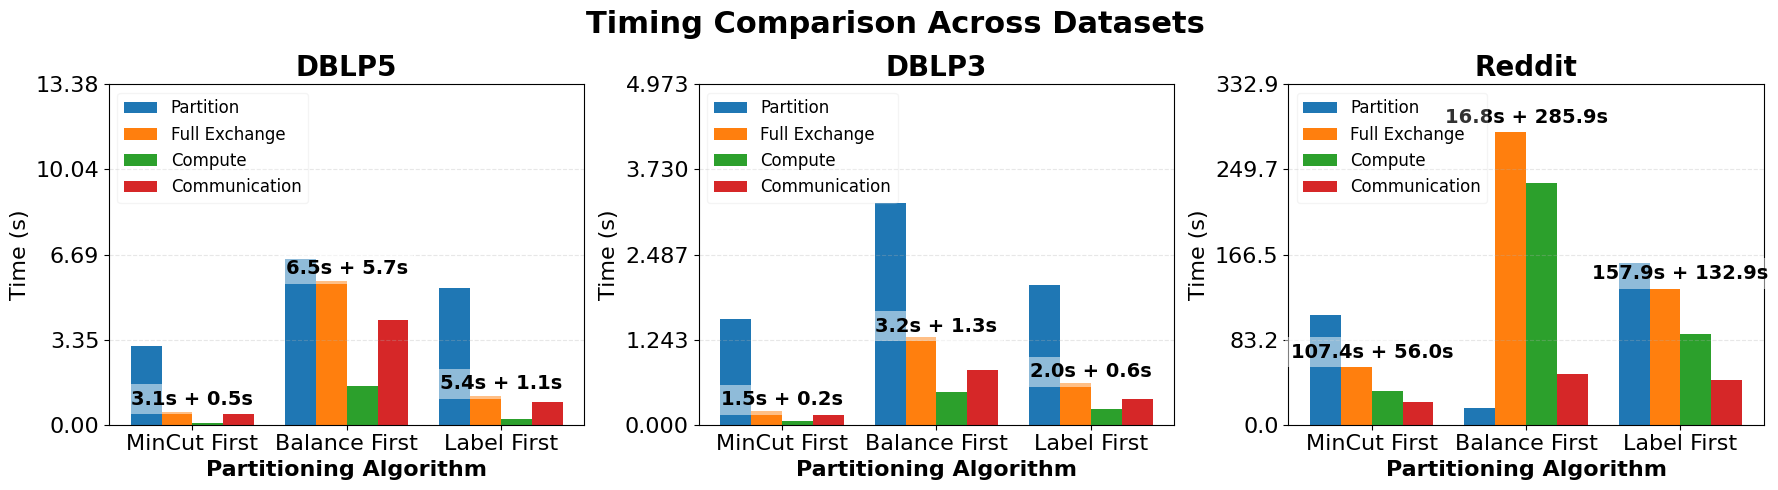

In [5]:
# df = print_time_table(file_paths, labels)
# plot_time_comparison(df, dataset=DATASET)

dataframes = []
dataset_names = []
# data = [
#     ['DBLP5', ["DBLP5_Label", "DBLP5_Louvain", "DBLP5_Metis", "DBLP5_MinCutFirst"], ['Label-skew', 'Louvain', 'Metis','CoLearnPartition']],
#     ['DBLP3', ["DBLP3_Label", "DBLP3_Louvain", "DBLP3_Metis", "DBLP3_MinCutFirst"], ['Label-skew', 'Louvain', 'Metis','CoLearnPartition']],
#     ['Reddit', ["Reddit_Label", "Reddit_Louvain", "Reddit_Metis", "Reddit_MinCutFirst"], ['Label-skew', 'Louvain', 'Metis','CoLearnPartition']],
# ]
for dataset, file_paths, labels in data:
    df = print_time_table(file_paths, labels)
    dataframes.append(df)
    dataset_names.append(dataset)

plot_three_datasets(dataframes, dataset_names)

## Recording Local Client's Accuracies over Snapshots

In [6]:
def parse_snapshot_local_accuracies(filepath):
    """
    Parses local accuracy values from the log file.
    Returns:
        snapshot_to_client_accuracies: dict mapping snapshot -> client_id -> list of accuracies
            {
                0: { 0: [...], 1: [...], ..., n: [...] },
                1: { ... }
            }
    """
    snapshot_to_client_accuracies = defaultdict(lambda: defaultdict(list))
    current_snapshot = None

    with open(filepath, "r") as file:
        for line in file:
            line = line.strip()

            # Detect snapshot
            snapshot_match = re.match(r"Snapshot (\d+)", line)
            if snapshot_match:
                current_snapshot = int(snapshot_match.group(1))

            # Detect local accuracies
            if "@Local> accuracy" in line and current_snapshot is not None:
                match = re.search(r"accuracy\s*=\s*\[([^\]]+)\]", line)
                if match:
                    str_values = match.group(1).split(',')
                    float_values = [float(x.strip()) for x in str_values]
                    for client_id, acc in enumerate(float_values):
                        if acc > 0:  # Filter out zero padding
                            snapshot_to_client_accuracies[current_snapshot][client_id].append(acc)

    return snapshot_to_client_accuracies

def plot_snapshot_client_accuracies(snapshot_to_client_accuracies):
    num_snapshots = len(snapshot_to_client_accuracies)
    num_cols = 2
    num_rows = (num_snapshots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows), squeeze=False)
    fig.suptitle("Client Accuracy per Epoch (Grouped by Snapshot)", fontsize=16, y=0.99)

    all_handles = []
    all_labels = []
    collected_labels = set()

    for idx, (snapshot, client_to_accs) in enumerate(sorted(snapshot_to_client_accuracies.items())):
        ax = axes[idx // num_cols][idx % num_cols]

        for client_id, acc_list in sorted(client_to_accs.items()):
            line, = ax.plot(acc_list, label=f'Client {client_id}', linewidth=1)
            
            # Collect handles only once per client (avoiding duplicates)
            if f'Client {client_id}' not in collected_labels:
                all_handles.append(line)
                all_labels.append(f'Client {client_id}')
                collected_labels.add(f'Client {client_id}')

        ax.set_title(f"Snapshot {snapshot}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0, 1)
        ax.grid(True)

    # Adjust layout and add global legend outside plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    fig.legend(all_handles, all_labels, loc='center left', bbox_to_anchor=(0.92, 0.5), title="Clients")

    plt.show()

def plot_combined_accuracy_and_edges(snapshot_to_client_accuracies, snapshot_to_subgraph_num_and_distribution):
    snapshots = sorted(snapshot_to_client_accuracies.keys())
    num_snapshots = len(snapshots)
    
    # Assume 10 clients (0-9); get consistent color mapping using a colormap
    client_ids = list(range(10))
    cmap = plt.colormaps.get_cmap('tab10')  # use tab10 for categorical color palette
    client_colors = {client: cmap(client) for client in client_ids}
    
    fig, axes = plt.subplots(num_snapshots, 2, figsize=(14, 4 * num_snapshots))
    fig.suptitle("Client Accuracy and Edge Count per Snapshot", fontsize=18, y=0.99)

    if num_snapshots == 1:
        axes = np.array([axes])  # ensure 2D array even for one snapshot

    for i, snapshot in enumerate(snapshots):
        # --- Bar chart (left) ---
        edge_ax = axes[i, 0]
        edge_data = snapshot_to_subgraph_num_and_distribution.get(snapshot, {})
        clients = sorted(edge_data.keys())
        edge_counts = [edge_data[client] for client in clients]

        bars = edge_ax.bar(
            clients, edge_counts,
            color=[client_colors[client] for client in clients]
        )
        edge_ax.set_title(f"Snapshot {snapshot}: Edge Distribution")
        edge_ax.set_xlabel("Client ID")
        edge_ax.set_ylabel("#Edges")
        edge_ax.grid(True, axis='y')

        # --- Line plot (right) ---
        acc_ax = axes[i, 1]
        client_to_accs = snapshot_to_client_accuracies[snapshot]
        for client_id, acc_list in sorted(client_to_accs.items()):
            acc_ax.plot(acc_list, label=f"Client {client_id}", linewidth=1.5, color=client_colors[client_id])

        acc_ax.set_title(f"Snapshot {snapshot}: Local Accuracy over Epochs")
        acc_ax.set_xlabel("Epoch")
        acc_ax.set_ylabel("Accuracy")
        acc_ax.set_ylim(0, 1)
        acc_ax.grid(True)

        # --- Per-row legend (only for the line plot) ---
        # handles, labels = acc_ax.get_legend_handles_labels()
        # acc_ax.legend(handles, labels, loc='upper right', fontsize=9)

    # Place one legend outside all line plots (shared)
    handles, labels = axes[0, 1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98), fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# local_accuracies = parse_snapshot_local_accuracies(experiment_to_results_path[DATASET])

In [7]:
# plot_combined_accuracy_and_edges(local_accuracies, snapshot_to_subgraph_num_and_distribution)

<h3> Take a look at the Global Accuracy over Snapshots

In [8]:
def parse_snapshot_file(file_path):
    snapshot_to_global_accs = defaultdict(list)
    snapshot = None

    with open(experiment_to_results_path[file_path], 'r') as f:
        for line in f:
            snapshot_num_search = re.search(r"Snapshot (\d+)", line)
            if snapshot_num_search is not None:
                snapshot = int(snapshot_num_search.group(1))

            if '@Cloud> accuracy' in line:
                round_global_acc = re.search(r"accuracy\s*=\s*([+-]?\d*\.\d+)", line)
                if round_global_acc is not None and snapshot is not None:
                    global_acc = float(round_global_acc.group(1))
                    snapshot_to_global_accs[snapshot].append((global_acc,))
    
    return snapshot_to_global_accs

def plot_global_accuracy(snapshot_data, label=None, color=None):
    all_values = []
    snapshot_start_indices = []
    index = 0

    for snapshot_id in sorted(snapshot_data.keys()):
        rounds = snapshot_data[snapshot_id]
        snapshot_start_indices.append(index)
        for item in rounds:
            all_values.append(item[0])
            index += 1

    plt.plot(range(1, len(all_values)+1), all_values, marker='o', label=label, color=color)

    for i, snapshot_start in enumerate(snapshot_start_indices):
        if snapshot_start > 0:
            plt.axvline(snapshot_start + 1, color='gray', linestyle='--', alpha=0.3)

def plot_multiple_global_accuracies(file_paths, labels):
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'black']  # extend as needed

    plt.figure(figsize=(10, 4))

    for i, (file_path, label) in enumerate(zip(file_paths, labels)):
        snapshot_data = parse_snapshot_file(file_path)
        plot_global_accuracy(snapshot_data, label=label, color=colors[i % len(colors)])

    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots", fontsize=25)
    plt.legend()
    plt.tight_layout()
    plt.show()

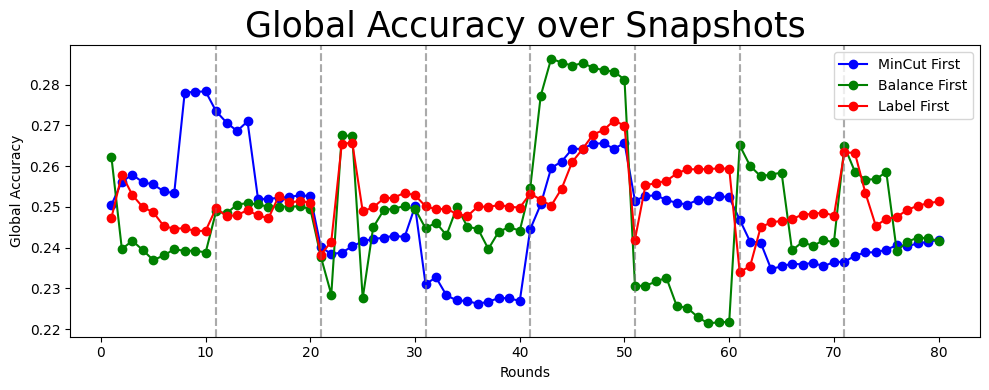

In [9]:
plot_multiple_global_accuracies(file_paths, labels)

## Extracting the Node Class Distributions for Node Classification Tasks

In [10]:
# def get_multi_index_table_for_label_distribution(snapshot_to_class_distribution):
#     df = pd.DataFrame.from_dict(
#         {(outer_k, inner_k): values for outer_k, inner_dict in snapshot_to_class_distribution.items() for inner_k, values in inner_dict.items()},
#         orient='index'
#     )

#     # Set MultiIndex
#     df.index = pd.MultiIndex.from_tuples(df.index, names=["Snapshot", "Class Labels"]).T

#     # Transpose the DataFrame
#     df_transposed = df.T

#     # Show all rows and columns
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.max_columns', None)
#     # df_transposed.to_csv("output.csv")
#     return df_transposed

# get_multi_index_table_for_label_distribution(snapshot_to_class_distribution)

### Calculate Shannon Entropy for Label Diversity

['DBLP5_MinCutFirst', 'DBLP5_BalanceFirst', 'DBLP5_LabelFirst']


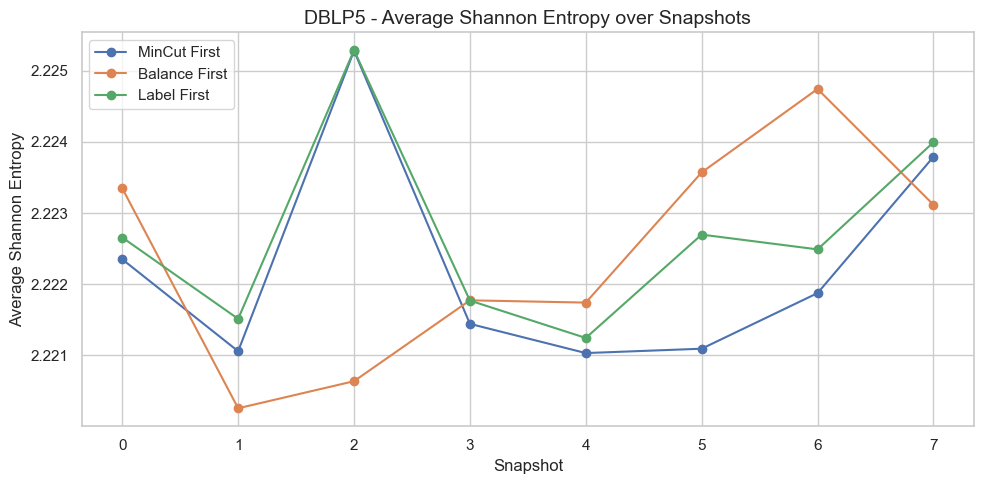

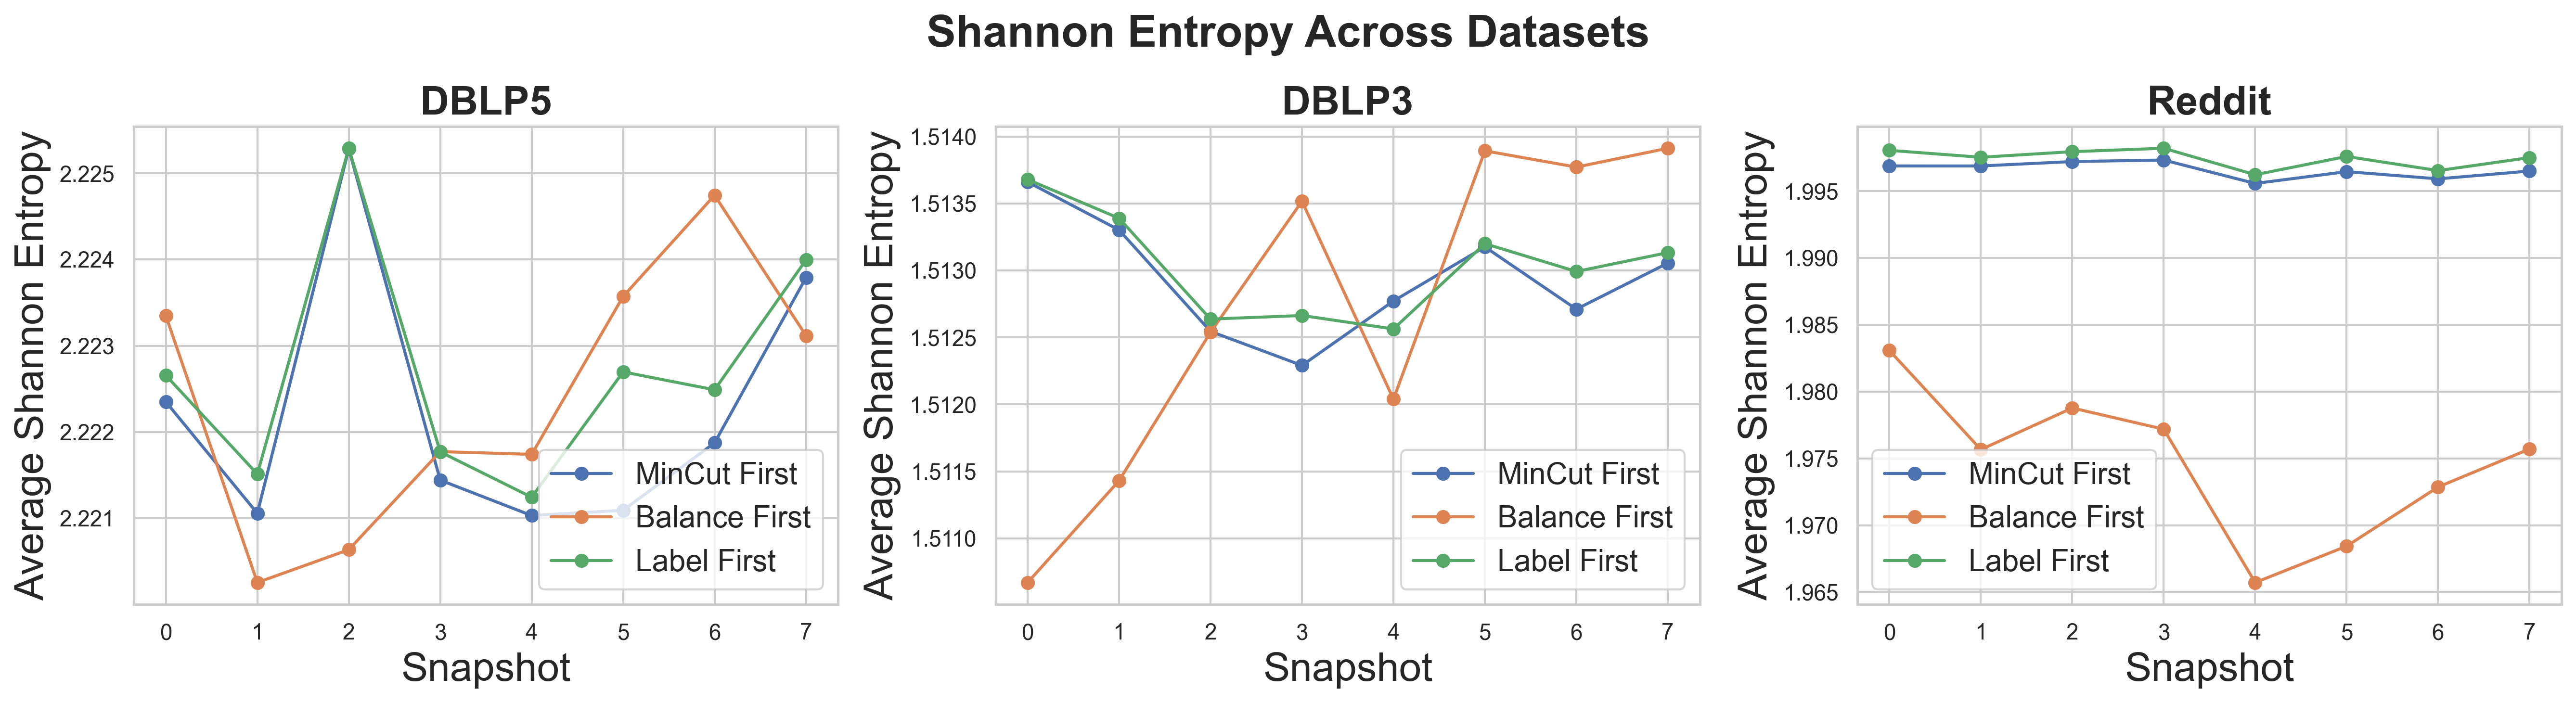

{'MinCut First': {0: 2.2223499707545544, 1: 2.221057549295672, 2: 2.225282792629264, 3: 2.2214424326606936, 4: 2.221031555156957, 5: 2.221092757293621, 6: 2.221874636512569, 7: 2.2237908652287204}, 'Balance First': {0: 2.2233482941597886, 1: 2.2202553814362718, 2: 2.2206360107380383, 3: 2.22177316351682, 4: 2.2217412604636464, 5: 2.2235718741322517, 6: 2.224744979254846, 7: 2.2231169653826632}, 'Label First': {0: 2.2226564099061594, 1: 2.2215127600998392, 2: 2.225289713822026, 3: 2.221769860394309, 4: 2.2212439376674826, 5: 2.2226972145031727, 6: 2.222489467705875, 7: 2.2239954215773117}}


In [22]:
def compute_shannon_entropy(label_counts: dict) -> float:
    total = sum(label_counts.values())
    if total == 0:
        return 0.0
    probs = np.array([count / total for count in label_counts.values()])
    return -np.sum(probs * np.log2(probs + 1e-12))  # small epsilon to prevent log(0)

def compute_snapshot_entropy(snapshot_to_class_distribution):
    snapshot_entropy = {}
    for snapshot, subgraph_label_dict in snapshot_to_class_distribution.items():
        entropies = []
        for subgraph, label_dist in subgraph_label_dict.items():
            entropy = compute_shannon_entropy(label_dist)
            entropies.append(entropy)
        if entropies:
            snapshot_entropy[snapshot] = np.mean(entropies)
        else:
            snapshot_entropy[snapshot] = 0.0
    return snapshot_entropy

def plot_entropy_across_snapshots(strategy_to_entropy_dict, dataset=""):
    plt.figure(figsize=(10, 5))
    for strategy, entropy_dict in strategy_to_entropy_dict.items():
        snapshots = sorted(entropy_dict.keys())
        entropy_values = [entropy_dict[s] for s in snapshots]
        plt.plot(snapshots, entropy_values, label=strategy, marker='o')

    plt.xlabel("Snapshot")
    plt.ylabel("Average Shannon Entropy")
    plt.title(f"{dataset} - Average Shannon Entropy over Snapshots", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_entropy_subplots(data):
    """Create side-by-side subplots for entropy across 3 datasets"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
    
    for i, (dataset_name, file_labels, strategy_names) in enumerate(data):
        ax = axes[i]
        strategy_to_entropy = defaultdict(dict)
        
        # Process each strategy for this dataset
        for strategy_label, strategy_name in zip(file_labels, strategy_names):
            # Assuming parse_log_file and other functions are available
            _, _, _, snapshot_to_class_distribution, *_ = parse_log_file(experiment_to_results_path[strategy_label])
            snapshot_entropy = compute_snapshot_entropy(snapshot_to_class_distribution)
            strategy_to_entropy[strategy_name] = snapshot_entropy
        
        # Plot for this dataset
        for strategy, entropy_dict in strategy_to_entropy.items():
            snapshots = sorted(entropy_dict.keys())
            entropy_values = [entropy_dict[s] for s in snapshots]
            ax.plot(snapshots, entropy_values, label=strategy, marker='o')
        
        ax.set_xlabel("Snapshot", fontsize=20)
        ax.set_ylabel("Average Shannon Entropy", fontsize=20)
        ax.set_title(f"{dataset_name}", fontsize=20, fontweight="bold")
        ax.legend(fontsize=15)
        ax.grid(True)
    plt.suptitle('Shannon Entropy Across Datasets', fontsize=22, y=0.97, fontweight="bold")
    plt.tight_layout()
    plt.show()

print(file_paths)
strategy_to_entropy = {}
for strategy, path in zip(labels, file_paths):
    _, _, _, snapshot_to_class_distribution, *_ = parse_log_file(experiment_to_results_path[path])
    snapshot_entropy = compute_snapshot_entropy(snapshot_to_class_distribution)
    strategy_to_entropy[strategy] = snapshot_entropy

plot_entropy_across_snapshots(strategy_to_entropy, dataset=DATASET)
plot_entropy_subplots(data)
print(strategy_to_entropy)

## Plot cut edges in each subgraph

In [12]:
def plot_edge(data, dataset):
    # Prepare data for plotting
    x = list(data.keys())  # X-axis (keys of the dictionary)
    num_bars = max(len(v) for v in data.values())  # Number of bars (length of the longest list)

    # Collect the values for each bar group
    values = [list(d.values()) for d in data.values()]
    
    # Pad shorter lists with 0s to match the longest one
    padded_values = [v + [0] * (num_bars - len(v)) for v in values]
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(padded_values, columns=[f'Client {i}' for i in range(num_bars)])
    df['Snapshot'] = x
    
    # Normalize the values to represent proportions
    df_proportions = df.drop(columns='Snapshot').apply(lambda x: x / x.sum(), axis=1)
    df_proportions['Snapshot'] = df['Snapshot']

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create the plot
    plt.figure(figsize=(12, 7))

    # Plot a stacked bar chart
    ax = df_proportions.set_index('Snapshot').plot(kind='bar', stacked=True, figsize=(12, 7),
                                                   colormap='viridis', width=0.8)
    plt.xlim(12,23)
    # Customize plot labels and title
    ax.set_xlabel('Snapshot Number', fontsize=12)
    ax.set_ylabel('Proportion of Edges', fontsize=12)
    ax.set_title(f'Stacked Bar Plot of Edge Distribution by Snapshot for {dataset}', fontsize=20, fontweight="bold")
    
    # Adjust the legend
    plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Tight layout
    plt.tight_layout()

    # Show plot
    plt.show()

def plot_cut_edges(data, dataset):
    # Extract the first and second elements of the tuple (cut and uncut edges)
    first_elements = [first for first, second in data.values()]  # cut edges
    second_elements = [second for first, second in data.values()]  # uncut edges

    # Prepare the x-axis (snapshot numbers)
    snapshots = list(data.keys())

    # Plotting
    sns.set(style="whitegrid")  # Set Seaborn style

    plt.figure(figsize=(10, 6))

    # Create a stacked bar plot
    bar_width = 0.8  # width of the bars
    index = np.arange(len(snapshots))  # X-axis positions

    # Plot the first (red) part of the bars (cut edges)
    plt.bar(index, first_elements, bar_width, color='red', label='Cut Edges')

    # Plot the second (blue) part of the bars (uncut edges) on top of the first
    plt.bar(index, second_elements, bar_width, bottom=first_elements, color='blue', label='Uncut Edges')

    # Customize the plot
    plt.xlabel('Snapshot Number', fontsize=12)
    plt.ylabel('Number of Edges', fontsize=12)
    plt.title(f'Cut and Uncut Edges by Snapshot for {dataset}', fontsize=17, fontweight="bold")

    # Set x-ticks to be the snapshot numbers
    plt.xticks(index, snapshots)

    # Add a legend
    plt.legend(title='Edge Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Tight layout
    plt.tight_layout()
    plt.show()

# both = defaultdict(tuple)
# snapshot = 0
# for cut, total in zip(snapshot_to_cut_edges.values(), snapshot_to_edges.values()):
#     both[snapshot] = (cut, total)
#     snapshot += 1

# plot_cut_edges(both, DATASET)

    Snapshot  Cut Edges  Total Edges  Cut Ratio        Dataset
0          0        579        12886   0.044932   MinCut First
1          1        302        16676   0.018110   MinCut First
2          2       1016        13740   0.073945   MinCut First
3          3       3400        18954   0.179382   MinCut First
4          4        207        32210   0.006427   MinCut First
5          5       2156        56098   0.038433   MinCut First
6          6        456        34446   0.013238   MinCut First
7          7        672        29772   0.022572   MinCut First
8          0       4137        12886   0.321046  Balance First
9          1       6281        16676   0.376649  Balance First
10         2       5206        13740   0.378894  Balance First
11         3       6054        18954   0.319405  Balance First
12         4      10330        32210   0.320708  Balance First
13         5      14342        56098   0.255660  Balance First
14         6       9237        34446   0.268159  Balanc

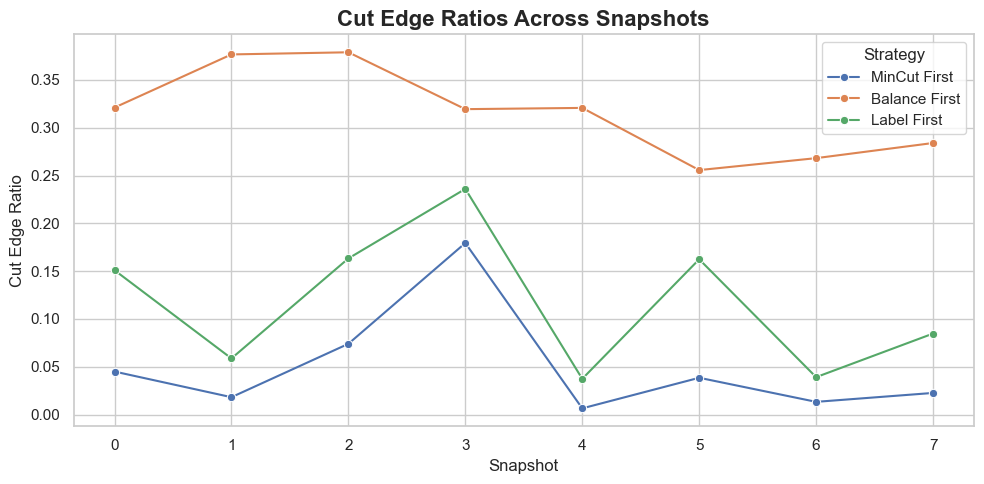

In [ ]:
def load_edge_data(file_path):
    snapshot_to_cut_edges = defaultdict(int)
    snapshot_to_edges = defaultdict(int)
    
    with open(experiment_to_results_path[file_path], 'r') as f:
        snapshot = 0
        for line in f:
            if "cut edges" in line:
                cut_edge_match = re.search(r"Total number of cut edges: (\d+)", line)
                if cut_edge_match is not None:
                    snapshot_to_cut_edges[snapshot] = int(cut_edge_match.group(1))
                    snapshot += 1

            if "A total" in line:
                edges_match = re.search(r"A total of (\d+) training edges", line)
                if edges_match is not None:
                    snapshot_to_edges[snapshot] = int(edges_match.group(1))

    return snapshot_to_cut_edges, snapshot_to_edges

def compute_cut_ratios(cut_edges, total_edges):
    ratios = {}
    for snap in cut_edges:
        cut = cut_edges[snap]
        total = total_edges.get(snap, 1)
        ratios[snap] = cut / total
    return ratios

def process_multiple_logs(file_paths, dataset_names):
    summary_table = pd.DataFrame()

    for file_path, dataset in zip(file_paths, dataset_names):
        cut_edges, total_edges = load_edge_data(file_path)
        ratios = compute_cut_ratios(cut_edges, total_edges)

        # Create a dataframe row for this dataset
        data = {
            'Snapshot': list(ratios.keys()),
            'Cut Edges': [cut_edges[k] for k in ratios],
            'Total Edges': [total_edges[k] for k in ratios],
            'Cut Ratio': [ratios[k] for k in ratios],
            'Dataset': dataset
        }
        df = pd.DataFrame(data)
        summary_table = pd.concat([summary_table, df], ignore_index=True)

    return summary_table

def plot_cut_ratios_table(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))

    sns.lineplot(data=df, x='Snapshot', y='Cut Ratio', hue='Dataset', marker='o')

    plt.title("Cut Edge Ratios Across Snapshots", fontsize=16, fontweight="bold")
    plt.ylabel("Cut Edge Ratio")
    plt.xlabel("Snapshot")
    plt.legend(title="Strategy")
    plt.tight_layout()
    plt.show()

df = process_multiple_logs(file_paths, labels)
plot_cut_ratios_table(df)

===DBLP5===
    Snapshot  Cut Edges  Total Edges  Cut Ratio        Dataset
0          0          3         2912   0.001030   MinCut First
1          1          1         3330   0.000300   MinCut First
2          2          3         3814   0.000787   MinCut First
3          3          2         4452   0.000449   MinCut First
4          4          3         5002   0.000600   MinCut First
5          5          4         4882   0.000819   MinCut First
6          6          4         4990   0.000802   MinCut First
7          7          5         4712   0.001061   MinCut First
8          0         10         2912   0.003434  Balance First
9          1         24         3330   0.007207  Balance First
10         2         23         3814   0.006030  Balance First
11         3          5         4452   0.001123  Balance First
12         4         33         5002   0.006597  Balance First
13         5         52         4882   0.010651  Balance First
14         6        190         4990   0.03

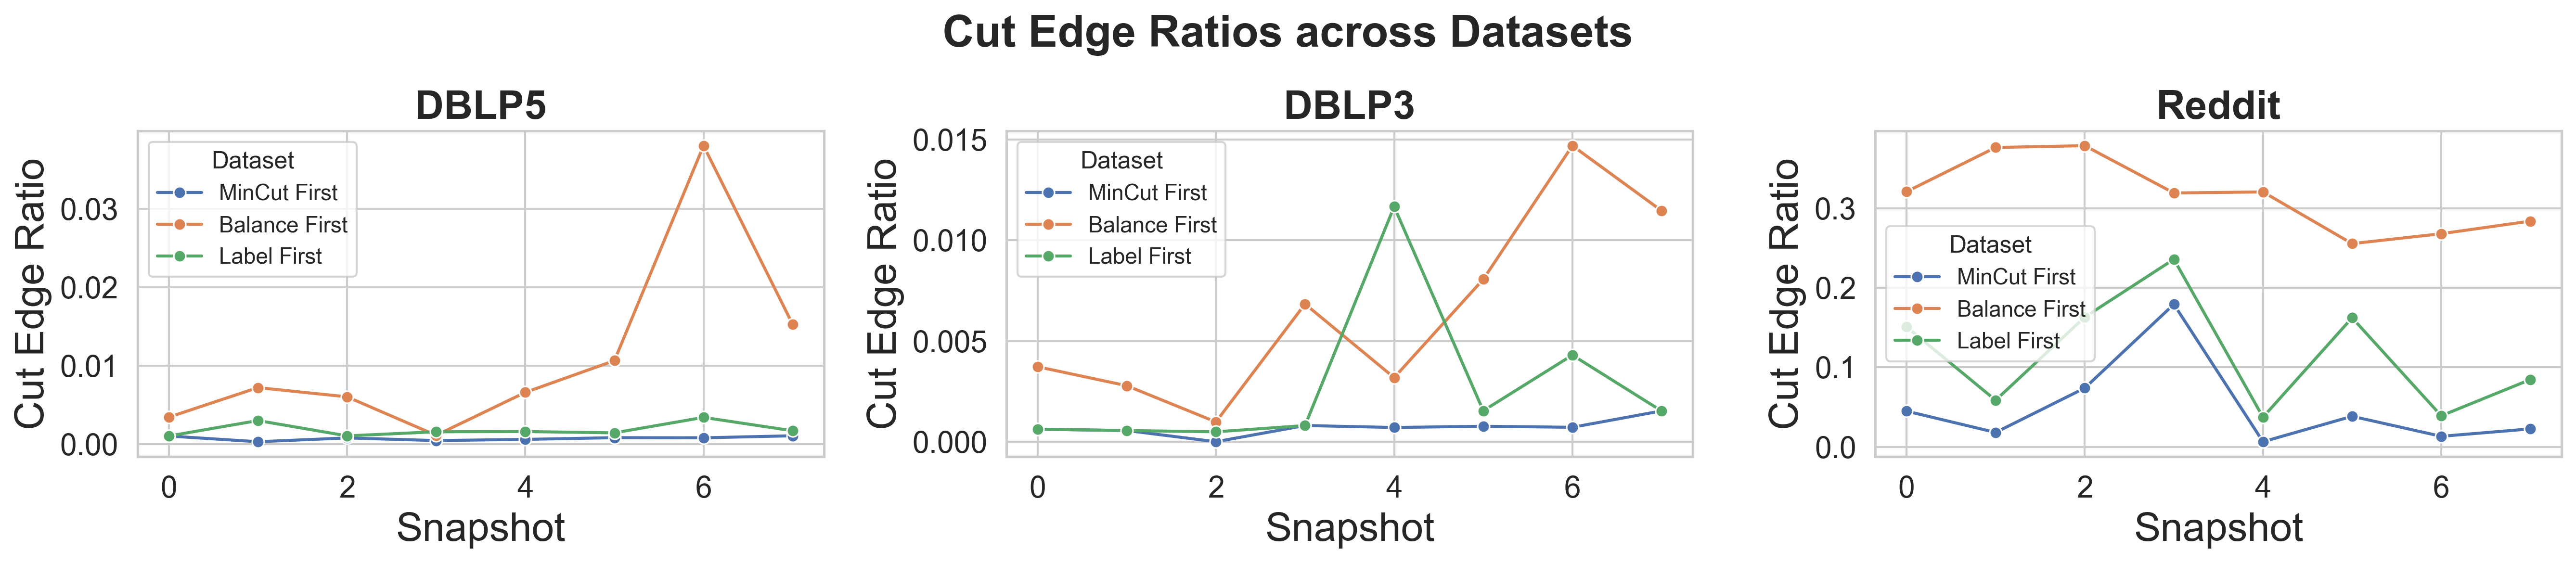

In [28]:
def plot_side_by_side_subplots(df_list, title_list):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), dpi=300)
    
    for i, (df, title) in enumerate(zip(df_list, title_list)):
        ax = axes[i]
        sns.lineplot(
            data=df,
            x='Snapshot',
            y='Cut Ratio',
            hue='Dataset',  # Change this to your actual column name
            marker='o',
            ax=ax
        )
        ax.set_title(f"{title}", fontsize=20, fontweight="bold")
        ax.set_xlabel("Snapshot", fontsize=20)
        ax.set_ylabel("Cut Edge Ratio", fontsize=20)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
    plt.suptitle('Cut Edge Ratios across Datasets', fontsize=22, y=0.97, fontweight="bold")
    plt.tight_layout()
    plt.show()

dataframes = []
dataset_names = []
data = [
    ['DBLP5', ["DBLP5_MinCutFirst", "DBLP5_BalanceFirst", "DBLP5_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
    ['DBLP3', ["DBLP3_MinCutFirst", "DBLP3_BalanceFirst", "DBLP3_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
    ['Reddit', ["Reddit_MinCutFirst", "Reddit_BalanceFirst", "Reddit_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
]
for dataset, file_paths, labels in data:
    df = process_multiple_logs(file_paths, labels)
    dataframes.append(df)
    dataset_names.append(dataset)
    import pandas as pd

    # Assuming your DataFrame is named 'df'
    average_cut_ratios = df.groupby('Dataset')['Cut Ratio'].mean()

    # To get them as individual variables:
    mincut_avg = average_cut_ratios['MinCut First']
    balance_avg = average_cut_ratios['Balance First']
    label_avg = average_cut_ratios['Label First']
    print(f"==={dataset}===")
    print(df)
    print(f"Average Cut Ratios:")
    print(f"MinCut First: {mincut_avg:.6f}")
    print(f"Balance First: {balance_avg:.6f}")
    print(f"Label First: {label_avg:.6f}")
plot_side_by_side_subplots(dataframes, dataset_names)

## Calculate Coefficient of Variation (CoV) for each snapshot

In [15]:
def compute_cov(values):
    if not values or np.mean(values) == 0:
        return 0.0
    return np.std(values) / np.mean(values)

def parse_snapshots(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    snapshot_data = defaultdict(lambda: {'train': [], 'val': [], 'test': []})
    current_snapshot = None

    for line in lines:
        snapshot_match = re.match(r"Snapshot (\d+)", line)
        if snapshot_match:
            current_snapshot = int(snapshot_match.group(1))
            continue

        client_match = re.match(
            r"Client \d+ has (\d+) positive training edges, (\d+) positive val edges and (\d+) positive test edges", 
            line
        )
        if client_match and current_snapshot is not None:
            train, val, test = map(int, client_match.groups())
            snapshot_data[current_snapshot]['train'].append(train)
            snapshot_data[current_snapshot]['val'].append(val)
            snapshot_data[current_snapshot]['test'].append(test)

    return snapshot_data

def compute_cov_per_snapshot(strategy_to_data):
    snapshot_ids = sorted(next(iter(strategy_to_data.values())).keys())

    train_covs = {strategy: [] for strategy in strategy_to_data}
    val_covs = {strategy: [] for strategy in strategy_to_data}
    test_covs = {strategy: [] for strategy in strategy_to_data}

    for snap_id in snapshot_ids:
        for strategy, data in strategy_to_data.items():
            train_cov = compute_cov(data[snap_id]['train'])
            val_cov = compute_cov(data[snap_id]['val'])
            test_cov = compute_cov(data[snap_id]['test'])

            train_covs[strategy].append(train_cov)
            val_covs[strategy].append(val_cov)
            test_covs[strategy].append(test_cov)

    return snapshot_ids, train_covs, val_covs, test_covs

def plot_cov_comparison(snapshot_ids, train_covs, val_covs, test_covs, dataset=''):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False, sharex=False, dpi=300)

    # Automatically assign distinct colors to each strategy
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    strategies = list(train_covs.keys())
    cmap = plt.colormaps.get_cmap('tab10')
    strategy_colors = {strategy: cmap(i) for i, strategy in enumerate(strategies)}

    # Set font sizes
    title_fontsize = 16
    label_fontsize = 16
    tick_fontsize = 12
    legend_fontsize = 12
    suptitle_fontsize = 20

    for ax, covs, title in zip(
        axes,
        [train_covs, val_covs, test_covs],
        ['Training Edge CoV', 'Validation Edge CoV', 'Test Edge CoV']
    ):
        for strategy, values in covs.items():
            ax.plot(snapshot_ids, values, label=strategy, marker='o', color=strategy_colors[strategy])
        ax.set_title(title, fontsize=title_fontsize, fontweight='bold')
        ax.set_xlabel('Snapshot', fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='center left', fontsize=14)

    axes[0].set_ylabel('Coefficient of Variation', fontsize=label_fontsize)

    # Put one legend outside to the right
    # fig.legend(strategies, loc='center left', bbox_to_anchor=(0.84, 0.5), fontsize=legend_fontsize)

    # Add super title and layout
    fig.suptitle(f'{dataset} CoV Comparison Across Strategies', fontsize=suptitle_fontsize, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0.05, 0.85, 1.0])
    plt.show()

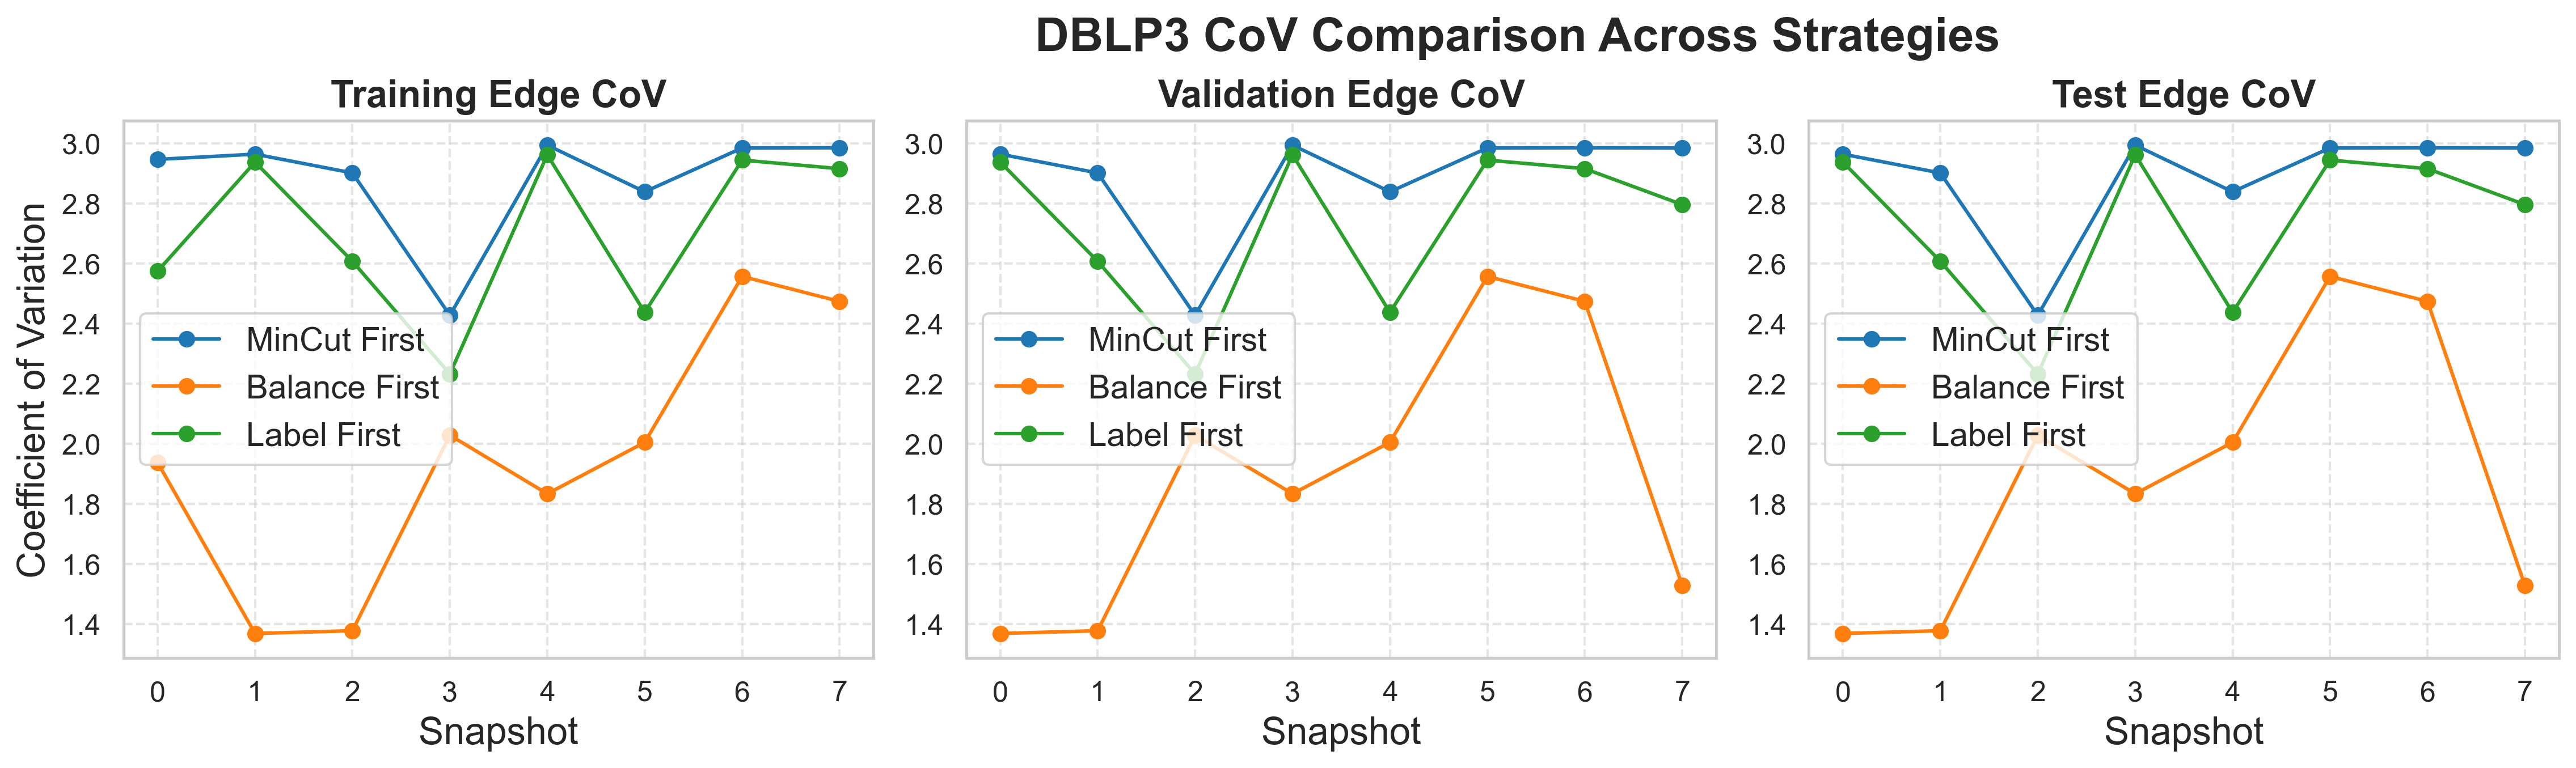

In [16]:
strategy_to_data = {}
for strategy_name, path_key in zip(labels, file_paths):
    data = parse_snapshots(experiment_to_results_path[path_key])
    strategy_to_data[strategy_name] = data

snapshot_ids, train_covs, val_covs, test_covs = compute_cov_per_snapshot(strategy_to_data)

plot_cov_comparison(snapshot_ids, train_covs, val_covs, test_covs, dataset=DATASET)

### Show Relationship between CoV and Clients' Local Accuracies

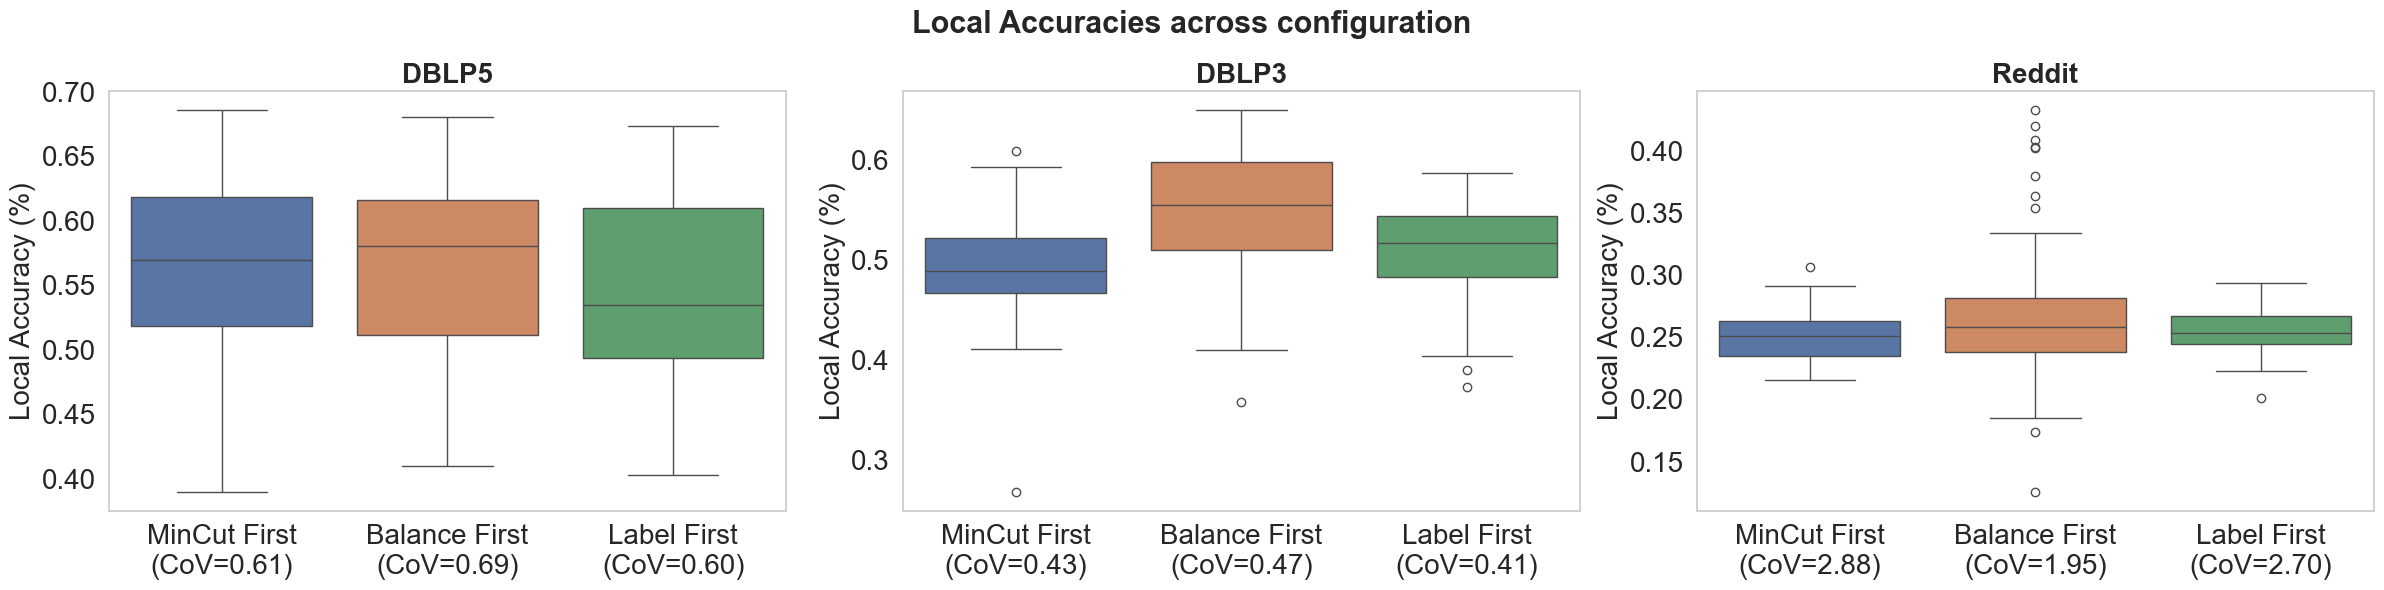

In [20]:
def cov_vs_acc(labels, file_paths):
    # === Collect accuracies and CoV values ===
    strategy_to_accuracies = {}
    strategy_to_cov = {}

    for strategy, filepath in zip(labels, file_paths):
        # Parse
        snapshot_data = parse_snapshots(experiment_to_results_path[filepath])
        acc_data = parse_snapshot_local_accuracies(experiment_to_results_path[filepath])

        # Compute CoV on training edges (averaged across snapshots)
        covs = []
        for snapshot in snapshot_data:
            train_sizes = snapshot_data[snapshot]['train']
            covs.append(compute_cov(train_sizes))
        avg_cov = np.mean(covs)
        strategy_to_cov[strategy] = avg_cov

        # Collect final local accuracy per client
        client_accs = []
        for snapshot in acc_data:
            for client_id in acc_data[snapshot]:
                # Take the final accuracy for this client at this snapshot
                if acc_data[snapshot][client_id]:
                    client_accs.append(acc_data[snapshot][client_id][-1])
        strategy_to_accuracies[strategy] = client_accs

    # === Plotting ===
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=[strategy_to_accuracies[strat] for strat in labels])
    plt.xticks(
        ticks=range(len(labels)),
        labels=[f"{strat}\n(CoV={strategy_to_cov[strat]:.2f})" for strat in labels],
        fontsize=15
    )
    plt.ylabel("Local Accuracy (%)", fontsize=15)
    plt.title(f"{DATASET} - Client Local Accuracies by Partitioning Strategy", fontsize=20, fontweight='bold')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def plot_client_accuracies_subplots(data):
    """Create side-by-side subplots for client accuracies across 3 datasets"""
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    for i, (dataset_name, file_labels, strategy_names) in enumerate(data):
        ax = axes[i]
        strategy_to_accuracies = {}
        strategy_to_cov = {}
        
        # Process each strategy for this dataset
        for strategy_label, strategy_name in zip(file_labels, strategy_names):
            # Assuming parse_snapshots and other functions are available
            snapshot_data = parse_snapshots(experiment_to_results_path[strategy_label])
            acc_data = parse_snapshot_local_accuracies(experiment_to_results_path[strategy_label])

            # Compute CoV
            covs = []
            for snapshot in snapshot_data:
                train_sizes = snapshot_data[snapshot]['train']
                covs.append(compute_cov(train_sizes))
            strategy_to_cov[strategy_name] = np.mean(covs)
            
            # Collect final accuracies
            client_accs = []
            for snapshot in acc_data:
                for client_id in acc_data[snapshot]:
                    if acc_data[snapshot][client_id]:
                        client_accs.append(acc_data[snapshot][client_id][-1])
            strategy_to_accuracies[strategy_name] = client_accs
        
        # Plot boxplot for this dataset
        sns.boxplot(
            data=[strategy_to_accuracies[strat] for strat in strategy_names],
            ax=ax
        )
        
        # Format x-axis labels with CoV values
        ax.set_xticks(
            ticks=range(len(strategy_names)),
            labels=[f"{strat}\n(CoV={strategy_to_cov[strat]:.2f})" for strat in strategy_names],
            fontsize=20
        )
        ax.tick_params(axis='y', labelsize=20)
        ax.set_ylabel("Local Accuracy (%)", fontsize=20)
        ax.set_title(f"{dataset_name}", fontsize=20, fontweight='bold')
        ax.grid(axis='y')
    
    plt.suptitle("Local Accuracies across configuration", fontsize=22, fontweight="bold")
    plt.tight_layout()
    plt.show()

data = [
    ['DBLP5', ["DBLP5_MinCutFirst", "DBLP5_BalanceFirst", "DBLP5_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
    ['DBLP3', ["DBLP3_MinCutFirst", "DBLP3_BalanceFirst", "DBLP3_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
    ['Reddit', ["Reddit_MinCutFirst", "Reddit_BalanceFirst", "Reddit_LabelFirst"], ['MinCut First', 'Balance First', 'Label First']],
]

plot_client_accuracies_subplots(data)
